<a href="https://colab.research.google.com/github/mafiTec/Clustering-DBSCAN-Customer-Response-Prediction/blob/main/Customer_Response_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data viz
import seaborn as sns #data viz
from sklearn.impute import SimpleImputer #imputes missing vals
from datetime import datetime 
from sklearn.preprocessing import StandardScaler, OneHotEncoder #preprocessing
from sklearn.compose import ColumnTransformer #preprocessing
from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.cluster import DBSCAN #clustering
from sklearn.model_selection import train_test_split, GridSearchCV #data split, grid search


In [2]:
customer_data = pd.read_csv('/content/drive/MyDrive/Kaggle/marketing_campaign.csv',sep='\t')
customer_data.head()

#customer_data = pd.read_csv('/content/drive/MyDrive/Kaggle/marketing_campaign.csv')
#customer_data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
#Feature Engineering
#Create 'Age' feature from customer's birth year
customer_data['Age'] = customer_data.Year_Birth.apply(lambda x: 2021 - int(x))

#Create 'Days_Since_Customer' feature from time the customer enrolled
customer_data['Dt_Customer'] = pd.to_datetime(customer_data.Dt_Customer)
now = datetime.now()
customer_data['Days_Since_Customer'] = customer_data.Dt_Customer.apply(lambda x: (now - x).total_seconds()/ (60 * 60 * 24))

#Create 'Fam_Size' feature from the marriage status, number of kids/teens
marital_map = {'Absurd': 1, 'Alone': 1, 'YOLO': 1, 'Single': 1,
              'Married': 2, 'Together': 2, 'Widow': 1, 'Divorced': 1}
customer_data['Marital_Status'] = customer_data.Marital_Status.map(marital_map) #Maps all singles as 1, couples as 2
customer_data['Num_Kids'] = customer_data.Kidhome.values + customer_data.Teenhome.values
customer_data['Fam_Size'] = customer_data.Marital_Status.values + customer_data.Num_Kids.values

#Create 'Num_Accepted' feature from the sum of previous marketting campaigns that were accepted by the customer
customer_data['Num_Accepted'] = customer_data.AcceptedCmp1.values + customer_data.AcceptedCmp2.values + \
                                customer_data.AcceptedCmp3.values + customer_data.AcceptedCmp4.values + \
                                customer_data.AcceptedCmp5.values

#Create 'MntTotal' for total amount spent on all items
customer_data['MntTotal'] = customer_data['MntWines'].values + customer_data['MntFruits'].values + \
                            customer_data['MntMeatProducts'].values + customer_data['MntFishProducts'].values + \
                            customer_data['MntWines'].values + customer_data['MntSweetProducts'].values + \
                            customer_data['MntGoldProds'].values

#Drops the unnecessary features from the original dataset
customer_data.drop(['Dt_Customer', 'Year_Birth', 'AcceptedCmp1', 'AcceptedCmp2',
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Kidhome', 'Teenhome',
                   'Z_CostContact', 'Z_Revenue', 'Num_Kids', 'Marital_Status'],
                   axis=1, inplace=True)
customer_data.head() 

,ID,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Days_Since_Customer,Fam_Size,Num_Accepted,MntTotal
0,5524,Graduation,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,64,3573.721469,1,0,2252
1,2174,Graduation,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,0,67,2727.721469,3,0,38
2,4141,Graduation,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,56,3074.721469,2,0,1202
3,6182,Graduation,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,37,2667.721469,3,0,64
4,5324,PhD,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,40,2923.721469,3,0,595


In [4]:
print('Dataset Shape:', customer_data.shape)
print('-------------------------------')
#Check if any columns contain null
print('Total Nulls Per Column:')
print(customer_data.isnull().sum())

Dataset Shape: (2240, 22)
-------------------------------
Total Nulls Per Column:
ID                      0
Education               0
Income                 24
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Response                0
Age                     0
Days_Since_Customer     0
Fam_Size                0
Num_Accepted            0
MntTotal                0
dtype: int64


In [5]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Income               2216 non-null   float64
 3   Recency              2240 non-null   int64  
 4   MntWines             2240 non-null   int64  
 5   MntFruits            2240 non-null   int64  
 6   MntMeatProducts      2240 non-null   int64  
 7   MntFishProducts      2240 non-null   int64  
 8   MntSweetProducts     2240 non-null   int64  
 9   MntGoldProds         2240 non-null   int64  
 10  NumDealsPurchases    2240 non-null   int64  
 11  NumWebPurchases      2240 non-null   int64  
 12  NumCatalogPurchases  2240 non-null   int64  
 13  NumStorePurchases    2240 non-null   int64  
 14  NumWebVisitsMonth    2240 non-null   int64  
 15  Complain             2240 non-null   i

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
la = LabelEncoder() 
customer_data['Education']=la.fit_transform(customer_data['Education'])

In [7]:
#Imputes the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(customer_data.Income.values.reshape(-1,1))
customer_data['Income'] = imputer.transform(customer_data.Income.values.reshape(-1,1))

In [8]:
#Calculate percent of responses
pos_resp = customer_data.Response.sum()
total = customer_data.shape[0]
percent = round((pos_resp / total)*100, 2)

print(pos_resp, 'customers responded to the marketing campaign out of a total of', total, 'cutomers.')
print('Percent Responded: ' +  str(percent) + '%')

334 customers responded to the marketing campaign out of a total of 2240 cutomers.
Percent Responded: 14.91%


In [9]:
#View feature correlations with the 'Response' column
#Note: 'Response' will be the target for predictive modeling
response_corr_abs = np.abs(customer_data.corr()['Response']).sort_values(ascending=False)[1:]
response_corr = customer_data.corr()['Response'].sort_values(ascending=False)[1:]
print("Correlation Coefficients for 'Response'")
print('--------------------------------------------------------')
print(response_corr)

Correlation Coefficients for 'Response'
--------------------------------------------------------
Num_Accepted           0.426035
MntTotal               0.265518
MntWines               0.247254
MntMeatProducts        0.236335
NumCatalogPurchases    0.220810
Days_Since_Customer    0.174061
NumWebPurchases        0.148730
MntGoldProds           0.139850
Income                 0.132756
MntFruits              0.125289
MntSweetProducts       0.117372
MntFishProducts        0.111331
Education              0.090819
NumStorePurchases      0.039363
NumDealsPurchases      0.002238
Complain              -0.001707
NumWebVisitsMonth     -0.003987
Age                   -0.021325
ID                    -0.021968
Recency               -0.198437
Fam_Size              -0.219440
Name: Response, dtype: float64


In [10]:
#Creates function to display kde graphs
def display_kdeplot(df, col1, col2):
    plt.figure(figsize=(8,8))
    sns.kdeplot(data=df, x=col1, hue=col2, multiple="stack")
    plt.title(col1 + ' correlation with ' + col2)
    plt.legend(['Response', 'No Response'])
    plt.show()
    print(df[col1].describe())

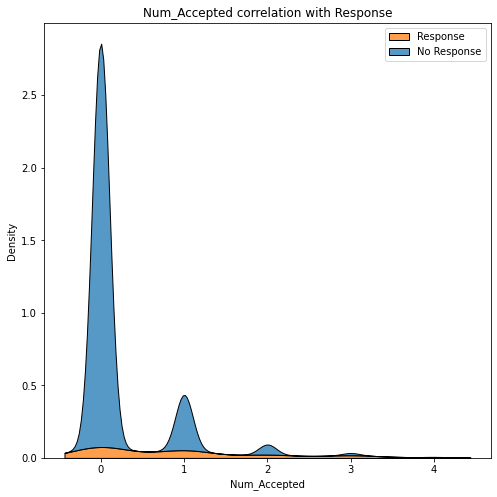

count    2240.000000
mean        0.297768
std         0.678381
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Num_Accepted, dtype: float64
Correlation %: 42.6
------------------------------------------------------------------------


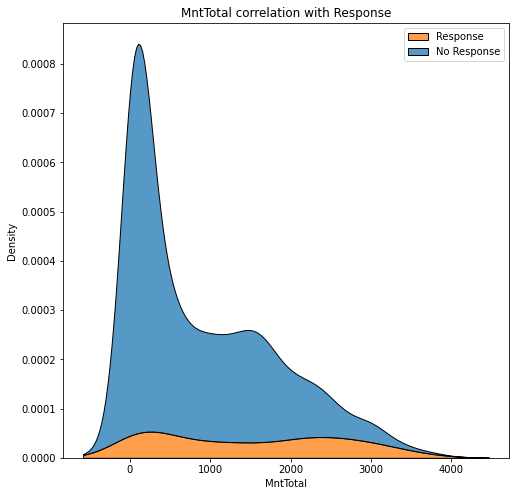

count    2240.000000
mean      909.733929
std       915.194547
min         7.000000
25%        90.750000
50%       579.500000
75%      1546.500000
max      3880.000000
Name: MntTotal, dtype: float64
Correlation %: 26.55
------------------------------------------------------------------------


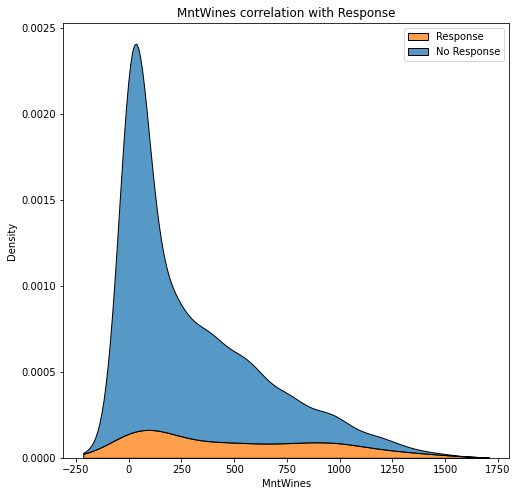

count    2240.000000
mean      303.935714
std       336.597393
min         0.000000
25%        23.750000
50%       173.500000
75%       504.250000
max      1493.000000
Name: MntWines, dtype: float64
Correlation %: 24.73
------------------------------------------------------------------------


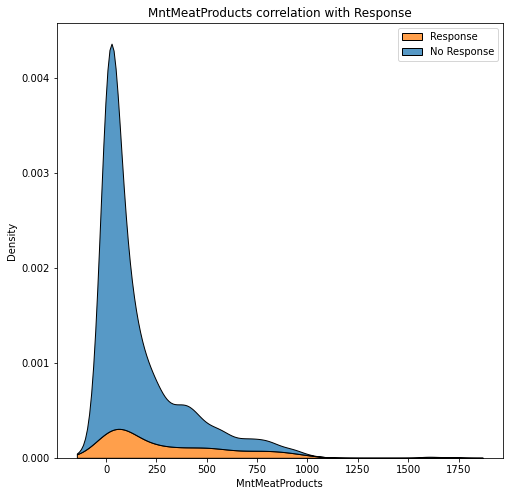

count    2240.000000
mean      166.950000
std       225.715373
min         0.000000
25%        16.000000
50%        67.000000
75%       232.000000
max      1725.000000
Name: MntMeatProducts, dtype: float64
Correlation %: 23.63
------------------------------------------------------------------------


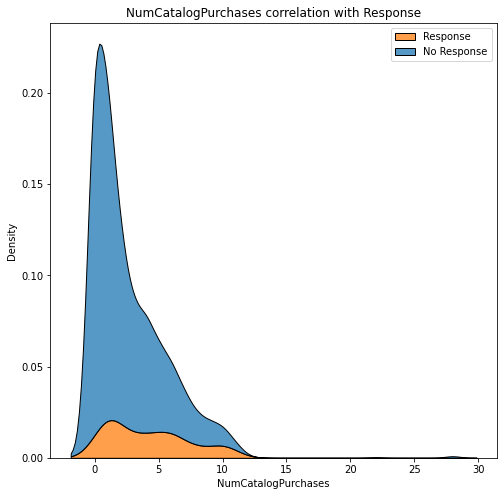

count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        28.000000
Name: NumCatalogPurchases, dtype: float64
Correlation %: 22.08
------------------------------------------------------------------------


In [11]:
for i in range(5):
    feature_name = response_corr_abs.index[i]
    display_kdeplot(customer_data, feature_name, 'Response')
    print('Correlation %:', round(response_corr[feature_name] * 100, 2))
    print('------------------------------------------------------------------------')

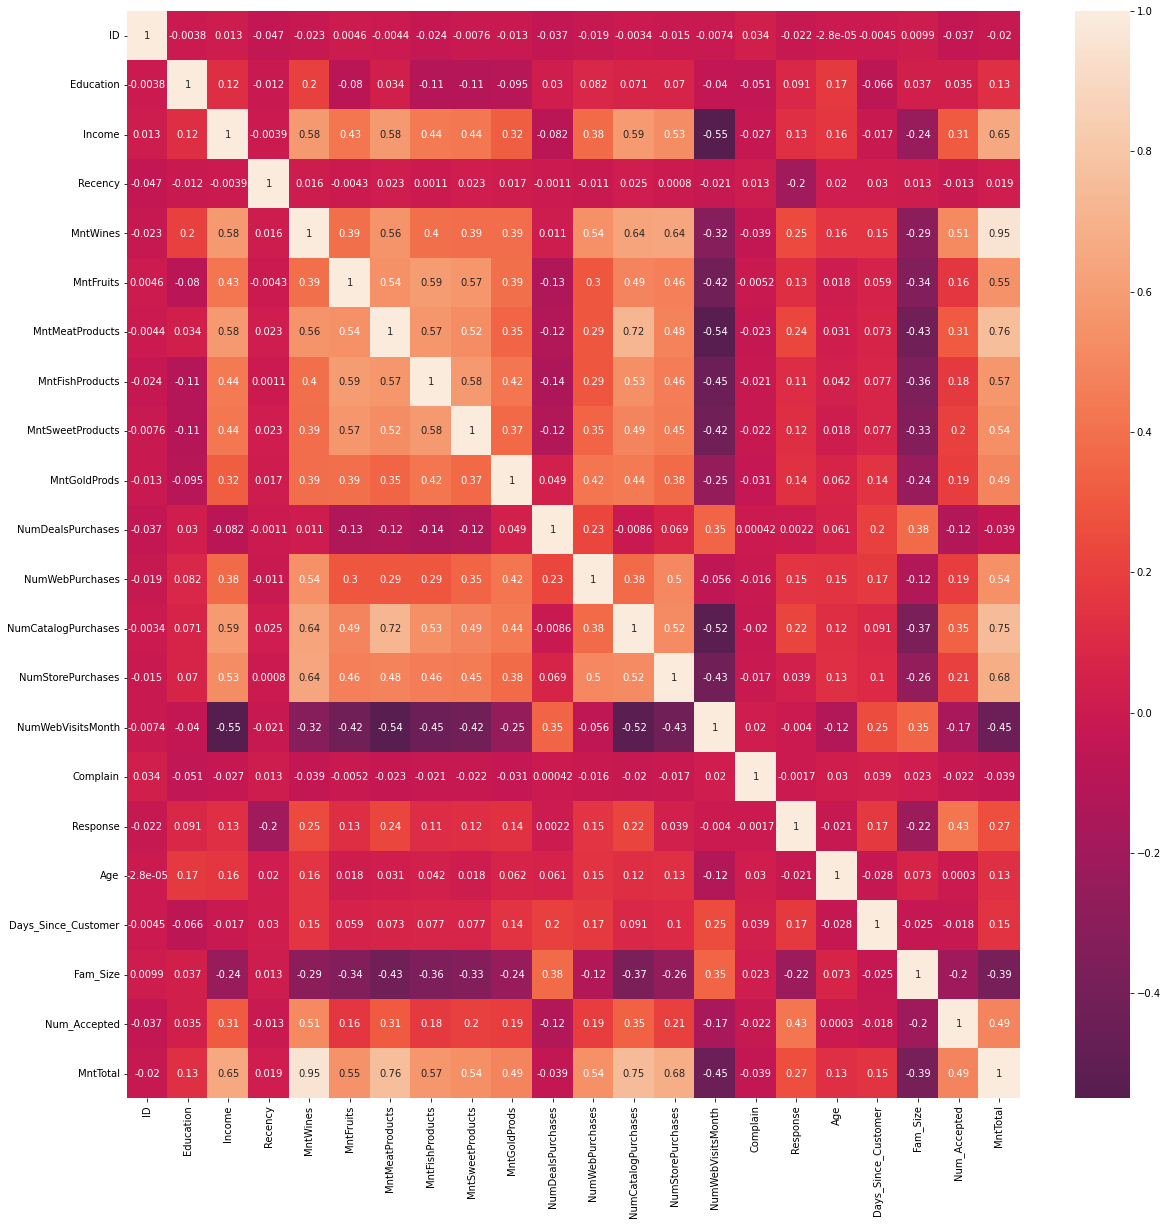

In [12]:
#plots the correlation matrix
plt.figure(figsize=(20,20))
cmap = sns.color_palette("rocket", as_cmap=True)
sns.heatmap(customer_data.corr(), annot=True, cmap=cmap, center=0)

In [13]:
#create function for plotting scatter plot
def display_scatterplot(df, col1, col2):
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=df, x=col1, y=col2, hue='Response')
    plt.title(col1 + ' correlation with ' + col2)
    plt.legend(['Response', 'No Response'])
    plt.show()

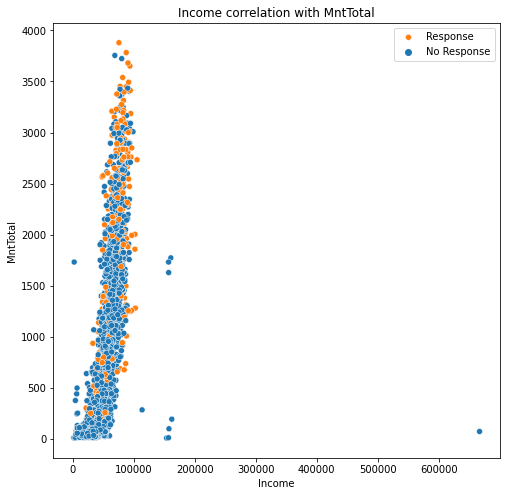

Correlation Coefficient %: 0.65
-----------------------------------------------------------


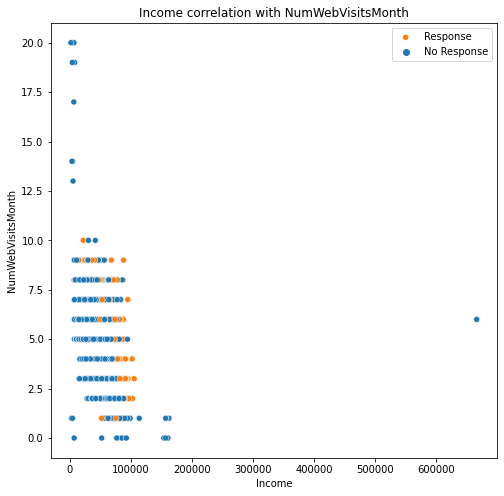

Correlation Coefficient %: -0.55
-----------------------------------------------------------


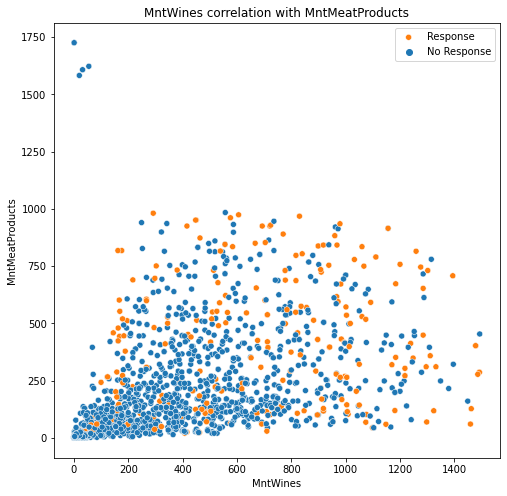

Correlation Coefficient %: 0.56
-----------------------------------------------------------


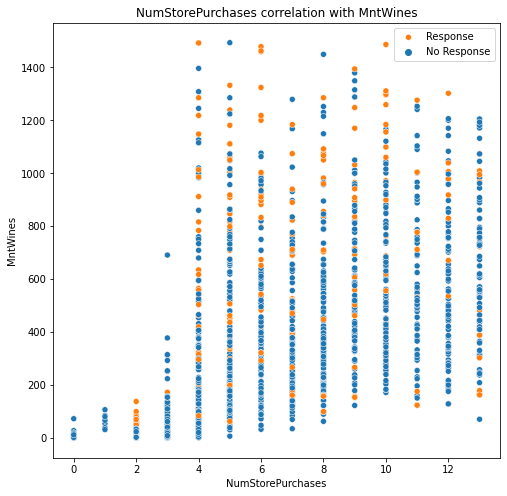

Correlation Coefficient %: 0.64
-----------------------------------------------------------


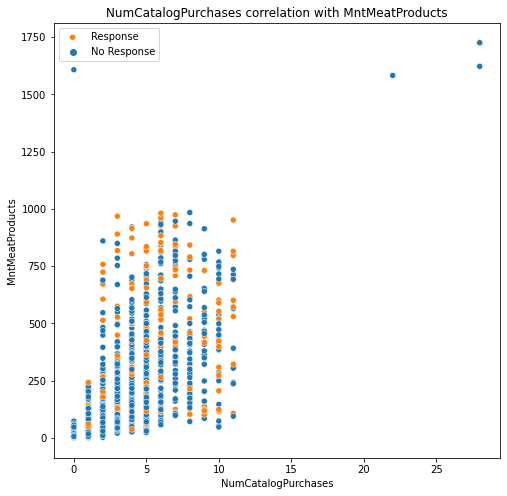

Correlation Coefficient %: 0.72
-----------------------------------------------------------


In [14]:
#Plots 5 features that have a med-high correlation selected from the above correlation matrix
corr_features = [['Income', 'MntTotal'], ['Income', 'NumWebVisitsMonth'], ['MntWines', 'MntMeatProducts'],
['NumStorePurchases', 'MntWines'], ['NumCatalogPurchases', 'MntMeatProducts']]
corr_mx = customer_data.corr()

for corr in corr_features:
    display_scatterplot(customer_data, corr[0], corr[1])
    print('Correlation Coefficient %:', round((corr_mx.loc[corr[0], corr[1]]), 2))
    print('-----------------------------------------------------------')


In [15]:
#Remove the 'Response' column because it is the target of future predictive model
X, y = customer_data.drop('Response', axis=1).values, customer_data['Response'].values

#Creates a column transformer that sends 'Education' to be encoded and rest scaled
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), [0]),
    ('numeric', StandardScaler(), list(range(1, len(X.T))))
])

#Sends the data through the column transformer
X_transformed = ct.fit_transform(X)
print('Preprocessed Data:')
print(X_transformed[0])

Preprocessed Data:
  (0, 1129)	1.0
  (0, 2240)	-0.3501412892118551
  (0, 2241)	0.23532677201008734
  (0, 2242)	0.30703926349227456
  (0, 2243)	0.9837812651523129
  (0, 2244)	1.5515769812186038
  (0, 2245)	1.6797023326128684
  (0, 2246)	2.4621470460734924
  (0, 2247)	1.4765001000700189
  (0, 2248)	0.8432069073861739
  (0, 2249)	0.349413940993261
  (0, 2250)	1.409303937080072
  (0, 2251)	2.5108902417547814
  (0, 2252)	-0.5507847897348009
  (0, 2253)	0.6939037392619777
  (0, 2254)	-0.09728166526882823
  (0, 2255)	0.9853447295662141
  (0, 2256)	1.9767445584266168
  (0, 2257)	-1.759114633956529
  (0, 2258)	-0.4390371310802406
  (0, 2259)	1.466973103060942


In [16]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()

In [17]:
customer_data_scaled = st.fit_transform(customer_data)

In [18]:
#Create instance of Principal Component Analysis in order to reduce dimensionality while maintaining variance
#n_components=3 will be chosen in order to visualize the data better
pca = PCA(n_components=3)

#fit to dataset
pca.fit(customer_data_scaled)

#create dimentionality reduced dataset
X_reduced = pca.transform(customer_data_scaled)

print('Dimentionality Reduced Data:')
print(X_reduced[0])

Dimentionality Reduced Data:
[ 4.41947675  1.05206756 -0.80687305]


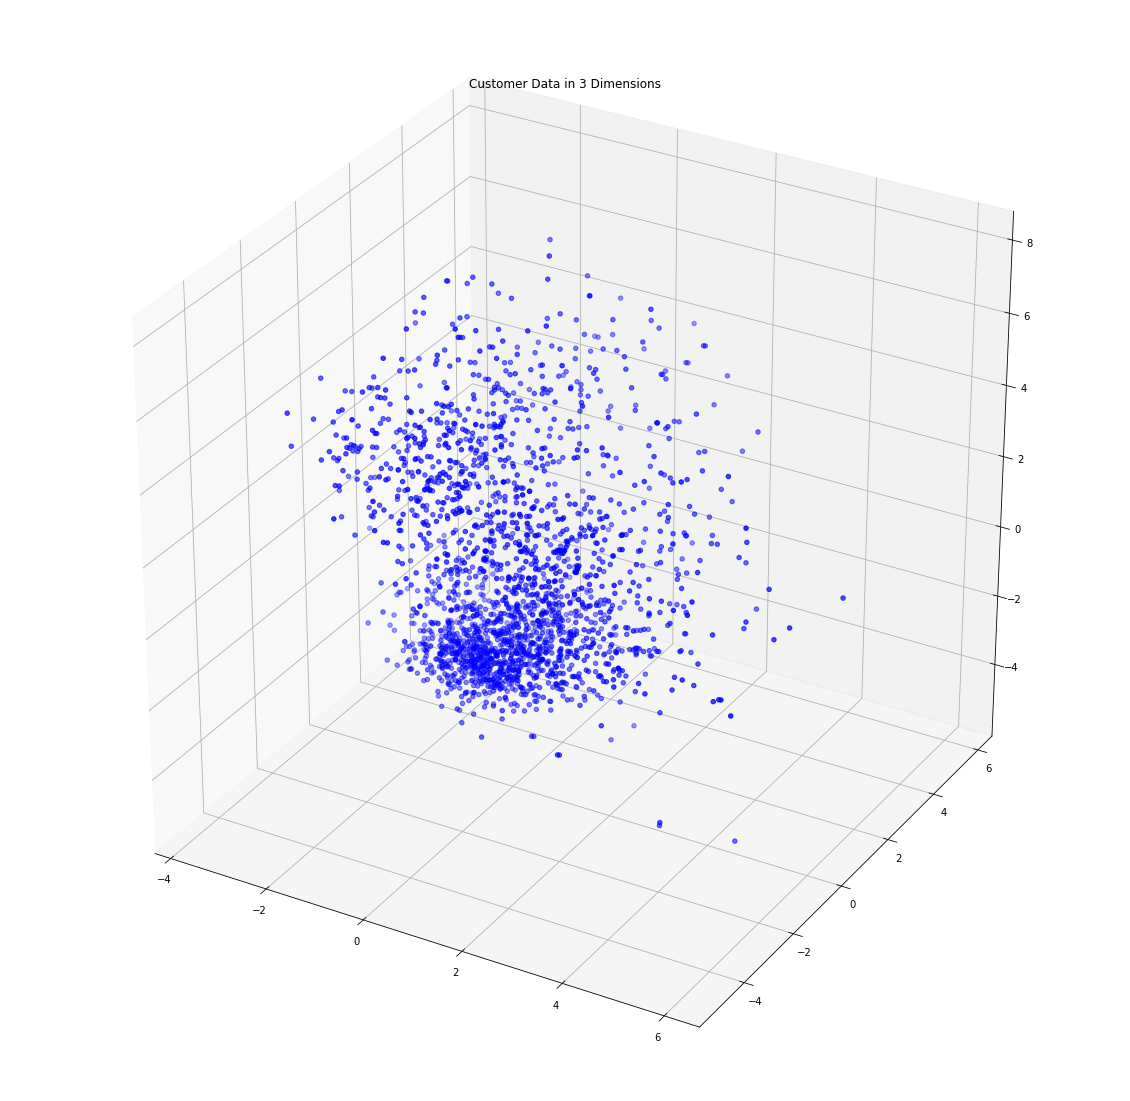

In [19]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c="blue")
ax.set_title("Customer Data in 3 Dimensions")
plt.show()

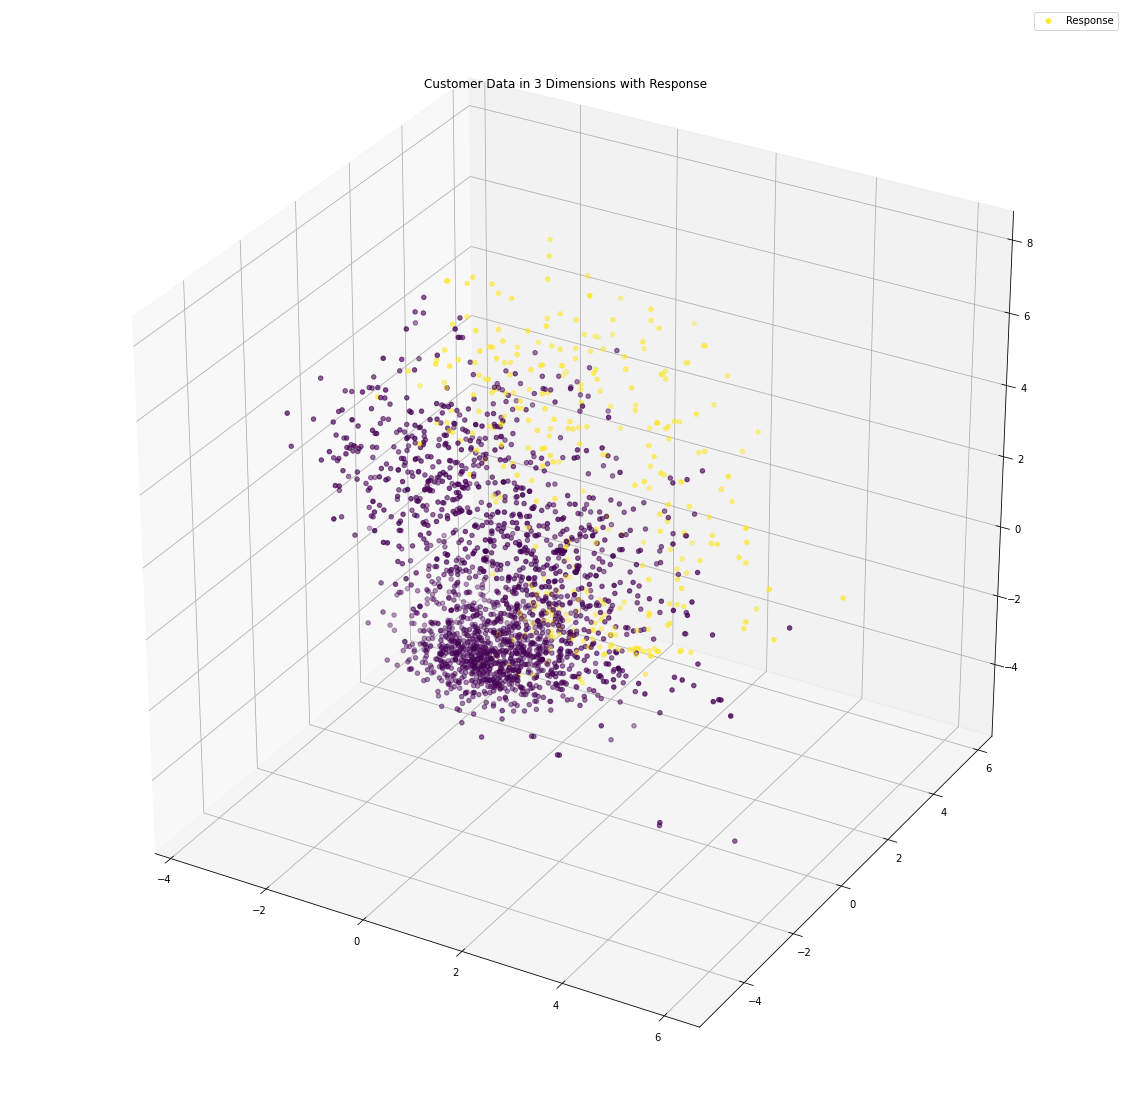

In [20]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c=y)
ax.set_title("Customer Data in 3 Dimensions with Response")
ax.legend(['Response'])
plt.show()

Clustering Customers

In [21]:
#Create an instance of DBSCAN to create non spherical clusters based on data density
db = DBSCAN(eps=0.726, min_samples=26)

#fit to the dimentionality reduced dataset
db.fit(X_reduced)

#identify the clusters
clusters = db.labels_

#display metrics/sample
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Cluster Predictions')
print('-------------------------------')
print("Number of clusters: %d" % n_clusters_)
print("Number of noise points: %d" % n_noise_)
print('Number of points per cluster:')
for i in range(n_clusters_):
    print('Cluster', i, ':', len(clusters[clusters==i]))

Cluster Predictions
-------------------------------
Number of clusters: 4
Number of noise points: 878
Number of points per cluster:
Cluster 0 : 1172
Cluster 1 : 40
Cluster 2 : 90
Cluster 3 : 60


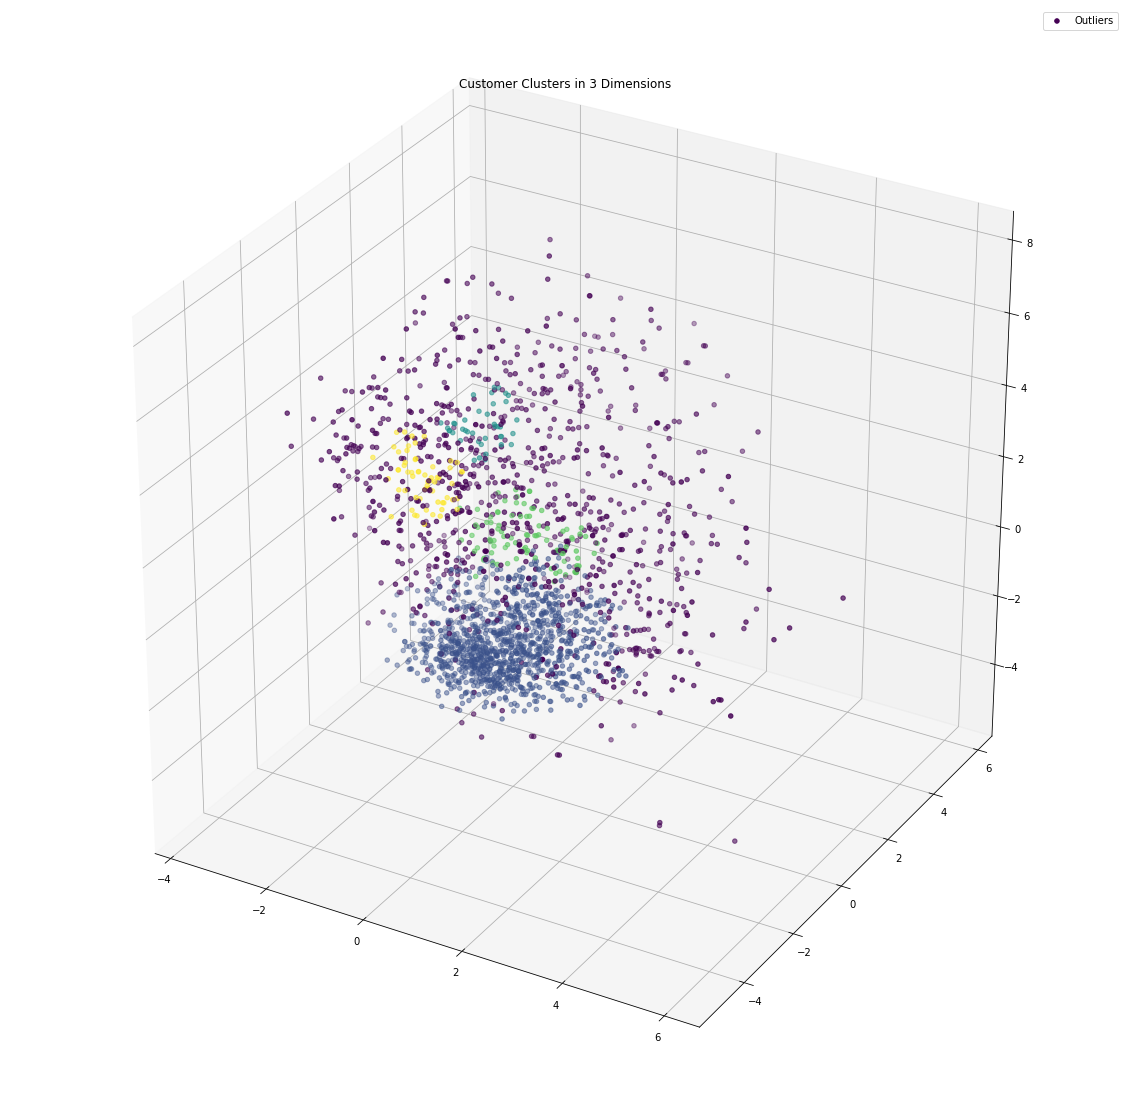

In [22]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], 
           c=clusters)
ax.set_title("Customer Clusters in 3 Dimensions")
ax.legend(['Outliers'])
plt.show()

In [23]:
#append the clusters to the original dataset
customer_data['Cluster'] = clusters

#group by cluster and calculate how many responses there were per cluster
cluster_grp = customer_data.groupby('Cluster').Response.agg(['sum', 'count'])
cluster_grp['percent_resp'] = cluster_grp['sum'].values / cluster_grp['count'].values
cluster_grp

,sum,count,percent_resp
Cluster,,,
-1,251,878,0.285877
0,72,1172,0.061433
1,10,40,0.250000
2,1,90,0.011111
3,0,60,0.000000


In [24]:
#create new dataframes for each cluster
outlier = customer_data[customer_data.Cluster == -1]
clus0 = customer_data[customer_data.Cluster == 0]
clus1 = customer_data[customer_data.Cluster == 1]
clus2 = customer_data[customer_data.Cluster == 2]

In [25]:
#Create function for plotting distributions per cluster
def create_kdeplot(col, title):
    plt.figure(figsize=(12,8))
    sns.kdeplot(data=outlier, x=col, label='Outliers')
    sns.kdeplot(data=clus0, x=col, label ='Cluster 0')
    sns.kdeplot(data=clus1, x=col, label ='Cluster 1')
    sns.kdeplot(data=clus2, x=col, label ='Cluster 2')
    plt.title(title)
    plt.legend()
    plt.show()
    
#Create function for plotting count of discrete values per cluster
def create_barplot(col, title):
    plt.figure(figsize=(8,8))
    sns.countplot(x=customer_data[col], hue=customer_data["Cluster"])
    plt.title(title)
    plt.legend(['Outliers', 'Cluster 0', 'Cluster 1', 'Cluster 2'])
    plt.show()

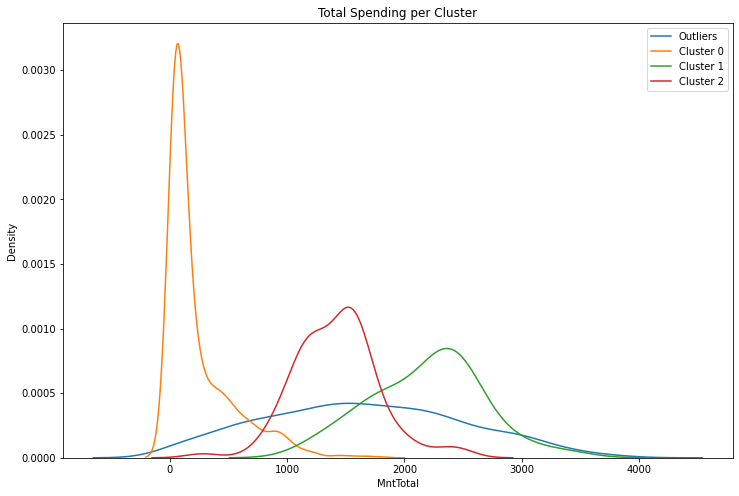

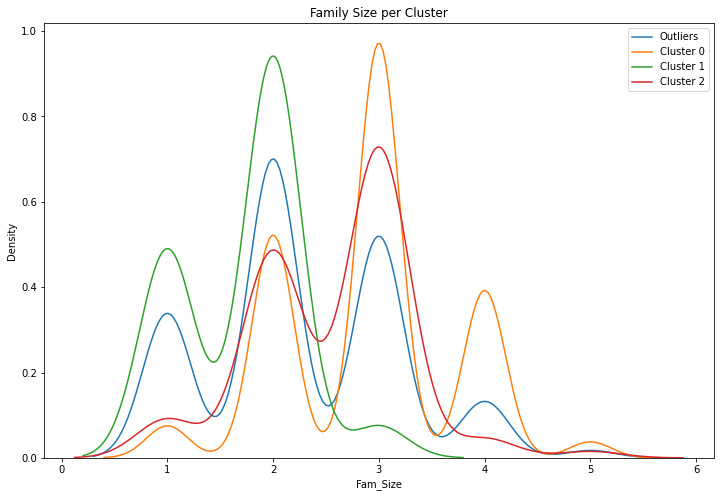

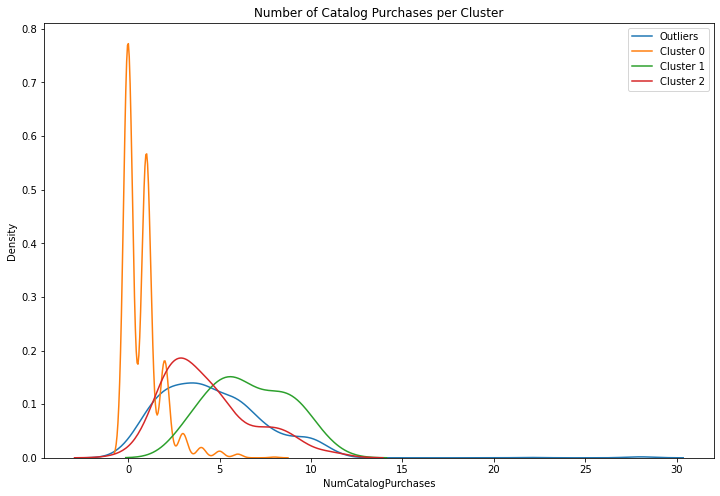

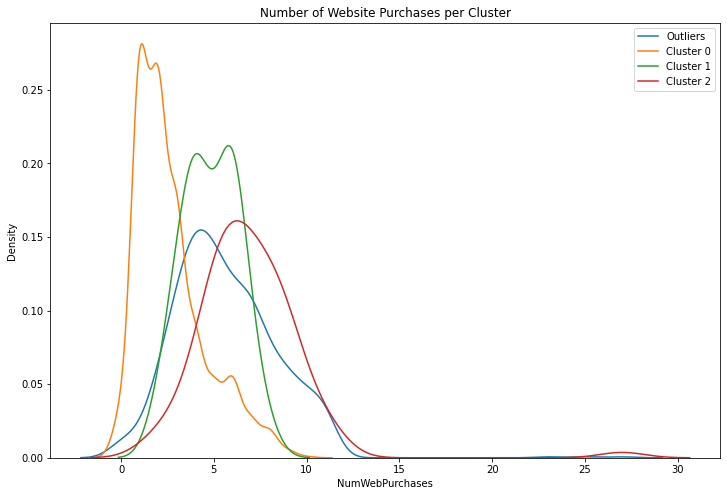

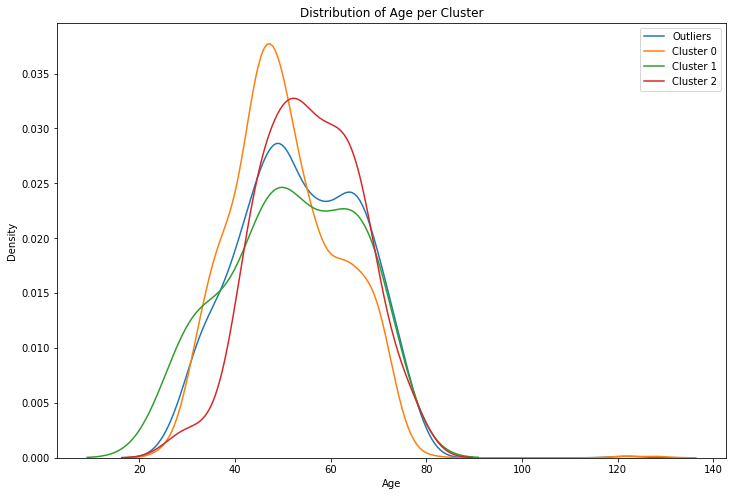

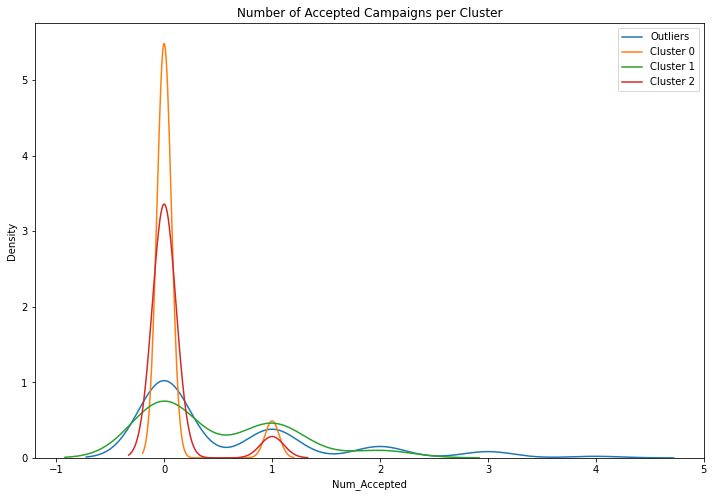

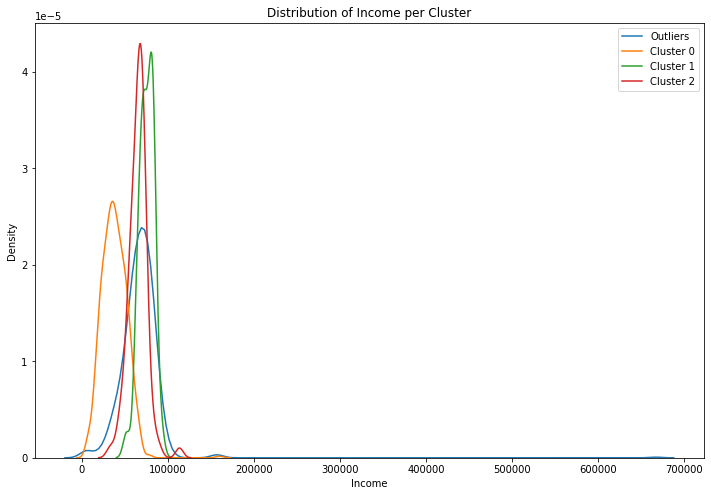

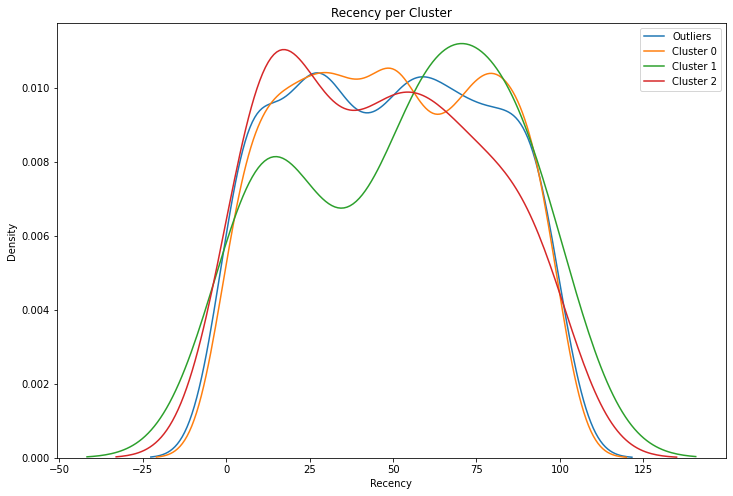

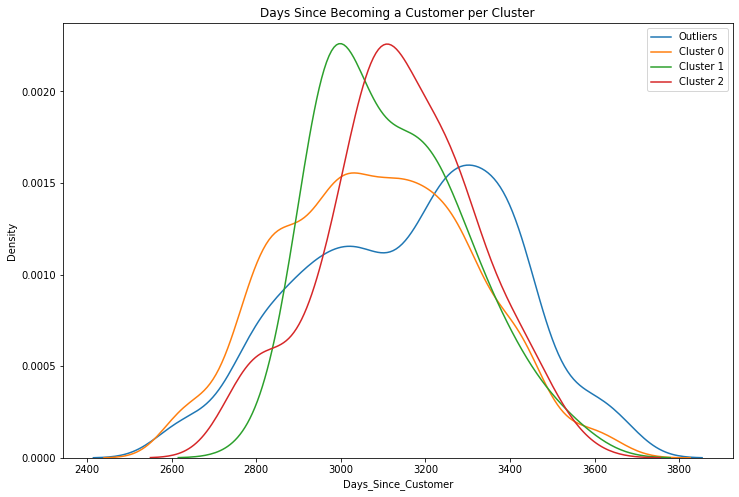

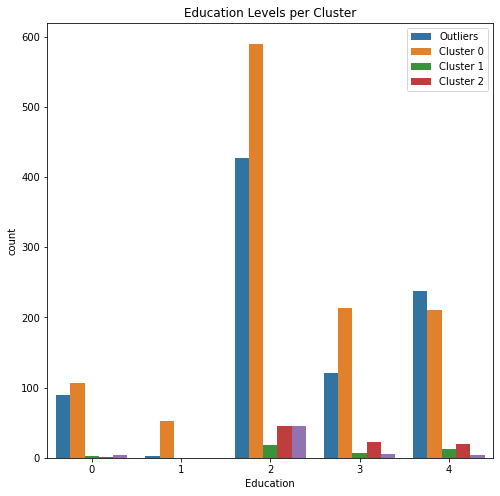

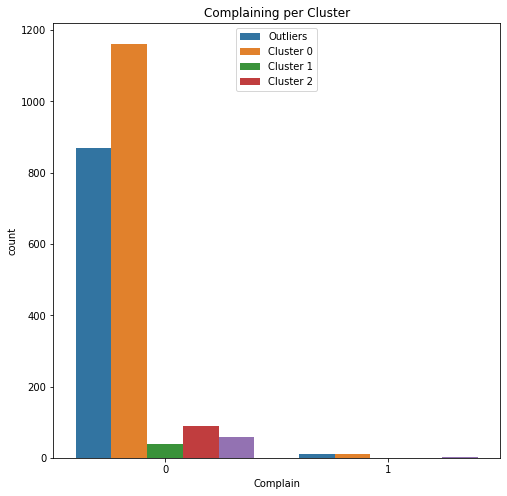

In [26]:
#Create list of variables to plot distributions
vars_to_kdeplot = [('MntTotal', 'Total Spending per Cluster'),
                ('Fam_Size', 'Family Size per Cluster'),
                ('NumCatalogPurchases', 'Number of Catalog Purchases per Cluster'),
                ('NumWebPurchases', 'Number of Website Purchases per Cluster'),
                ('Age', 'Distribution of Age per Cluster'),
                ('Num_Accepted', 'Number of Accepted Campaigns per Cluster'),
                ('Income', 'Distribution of Income per Cluster'),
                  ('Recency', 'Recency per Cluster'),
                  ('Days_Since_Customer', 'Days Since Becoming a Customer per Cluster')]

#Create list of variables to plot in bar graph
vars_to_barplot = [('Education', 'Education Levels per Cluster'),
                  ('Complain', 'Complaining per Cluster')]


#plot all kde plots
for var in vars_to_kdeplot:
    create_kdeplot(var[0], var[1])

#plot all bar plots
for var in vars_to_barplot:
    create_barplot(var[0], var[1])

In [27]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


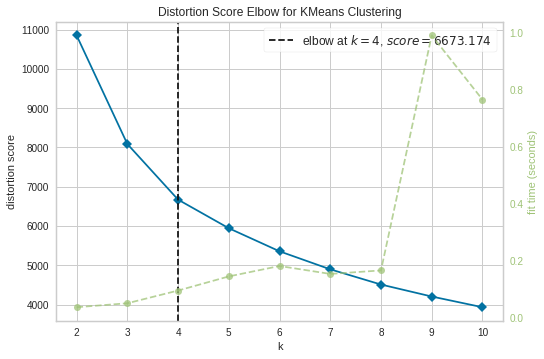

In [28]:
km = KMeans()
Elbow_M = KElbowVisualizer(estimator = km, k = 10)
Elbow_M.fit(X_reduced)
Elbow_M.show()
plt.show()


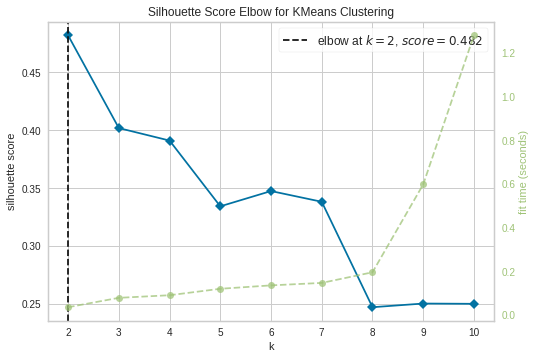

In [29]:
Elbow_M = KElbowVisualizer(estimator = km, k = 10, metric='silhouette')
Elbow_M.fit(X_reduced)
Elbow_M.show()

plt.show()


In [30]:
Km = KMeans(n_clusters= 4, random_state=8)
Model = km.fit_predict(X_reduced)


In [31]:
 X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [32]:
print(X_train.shape)
print(X_test.shape)

(1500, 21)
(740, 21)


In [33]:
print(y_train.shape)
print(y_test.shape)

(1500,)
(740,)


In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [35]:
k_range = range(1,26)
scores = {}
scores_list = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  scores[k] = metrics.accuracy_score(y_test, y_pred)
  scores_list.append(metrics.accuracy_score(y_test,y_pred))


Text(0, 0.5, 'Testing Accuracy')

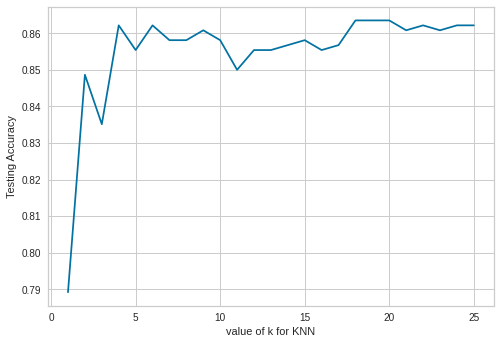

In [36]:
plt.plot(k_range, scores_list)
plt.xlabel('value of k for KNN')
plt.ylabel('Testing Accuracy')